In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA


# Titanic Dataset Analysis

In [3]:
data = sns.load_dataset('titanic')

In [4]:
df = pd.DataFrame(data)

# Exploratory Data Analysis

### Target: survival of passengers 
Type Classification, Binary 0 = Passed away 1 = Survived

# Dataset Overview

In [5]:
describe = df.describe()

In [6]:
describe

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Describtion:
- Dataset includes catergorical values mostly like (0 = Died and 1 = survivors)
- There are Five numerical columns so Labelencoding will be deployed when it is needed
- Age feature will dominate other features, StandardScaler is deployed

In [7]:
info = df.info()
info

<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    str     
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    str     
 8   class        891 non-null    category
 9   who          891 non-null    str     
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    str     
 13  alive        891 non-null    str     
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), str(5)
memory usage: 80.7 KB


### Insights of Info:
- There are 891 samples overall
- deck columns is useless since there are over 600 Nan values ==> Dropped
- age feature can be compremised by a simple replacement, replace median of values with Nan
- embark_town has about 10 missing values, it can be considered as a fraction of dataset hence I drop those samples
- There is no mismatch among all features type

In [8]:
typesC = df.dtypes
types = pd.DataFrame(typesC)
types.transpose()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,int64,int64,str,float64,int64,int64,float64,str,category,str,bool,category,str,str,bool


In [9]:
c = df.columns # this variable will be used during project 

# Titanic Dataset Column Explanation

## Target Variable
- **survived**: 0 = Did not survive, 1 = Survived.  
  This is the target variable for classification.

## Ticket / Socioeconomic Information
- **pclass**: Passenger class (1 = First, 2 = Second, 3 = Third).  
  Reflects socioeconomic status; higher class usually had higher survival.
- **fare**: Ticket price (numeric). Right-skewed; higher fare often correlates with higher class.

## Demographics
- **sex**: male / female. Strong predictor of survival.
- **age**: Passenger age in years. Contains missing values; important for survival analysis.
- **who**: man / woman / child. Derived from `sex` + `age`.
- **adult_male**: True / False. True = male and age ≥ 18. Derived feature.

## Family Information
- **sibsp**: Number of siblings/spouses aboard.
- **parch**: Number of parents/children aboard.
- **alone**: True / False. True = passenger had no family aboard. Derived from `sibsp` + `parch`.

## Location & Boarding
- **embarked**: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).
- **embark_town**: Same as `embarked` but full names.
- **deck**: Cabin deck (A–G). Many missing values; higher decks closer to lifeboats.

## Class & Target Redundancy
- **class**: First / Second / Third. Same as `pclass`.
- **alive**: yes / no. Same as `survived`.

## ⚠️ Notes on Redundant Columns
Some columns overlap or duplicate information:

- `class` → `pclass`  
- `embark_town` → `embarked`  
- `alive` → `survived`  
- `who` → `sex` + `age`  
- `adult_male` → `sex` + `age`  
- `alone` → `sibsp` + `parch`  

> When modeling, redundant or target-leaking columns should be removed.


# Dataset Overall Visualization and Insights

## Objectives

1. Analyze survival distribution (class imbalance check).
2. Examine survival rate based on gender.
3. Examine survival rate based on passenger class (socioeconomic status).
4. Analyze survival patterns across different age groups (age binning required).
5. Investigate the impact of ticket fare on survival.
6. Explore survival differences by embarkation port.
7. Analyze family size effect on survival (sibsp + parch).
8. Investigate whether passengers traveling alone had different survival rates.
9. Detect outliers in numerical features (Age, Fare).
10. Identify correlations between numerical variables and detect multicollinearity.

## Expected Insights

- Determine the strongest predictors of survival.
- Identify potential feature engineering opportunities.
- Detect redundant or leakage-prone variables.
- Understand data imbalance and distribution issues.

#### Analyze survival distribution (class imbalance check).

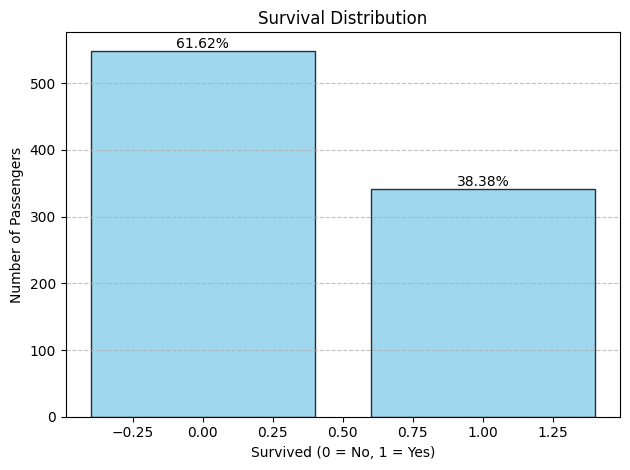

In [10]:
survivals = df["survived"].value_counts()

plt.bar(
    x=survivals.index,
    height=survivals.values,
    color="skyblue",
    edgecolor="black",
    alpha=0.8
)


total = len(df)

percentages = survivals/ total * 100

for i in range(len(survivals)): # 0 and 1
        plt.text(
                survivals.index[i], #==> output is 0 and 1
                survivals.values[i], # ==> output is 61.62 and 38.38
                f"{percentages.iloc[i]:.2f}%",  # text
                ha = "center",
                va = "bottom"
        )
    
    
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Number of Passengers")
plt.title("Survival Distribution")
plt.grid(axis="y", alpha=0.8, linestyle="--")
plt.tight_layout()
plt.show()

#### Examine survival rate based on gender.

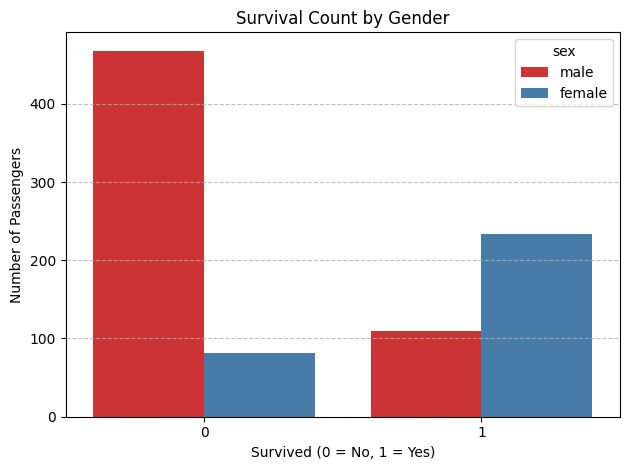

In [11]:
sns.countplot(data=df,x="survived",hue="sex", palette="Set1")
plt.title("Survival Count by Gender")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Number of Passengers")
plt.grid(axis="y", alpha=0.8, linestyle="--")
plt.tight_layout()
plt.show()

#### Examine survival rate based on passenger class (socioeconomic status).

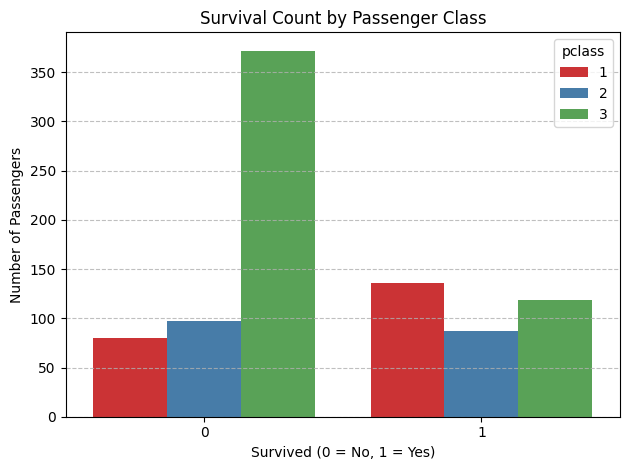

In [12]:
sns.countplot(data=df, x="survived", hue="pclass", palette="Set1")


plt.title("Survival Count by Passenger Class")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Number of Passengers")

plt.grid(axis="y", alpha=0.8, linestyle="--")
plt.tight_layout()
plt.show()

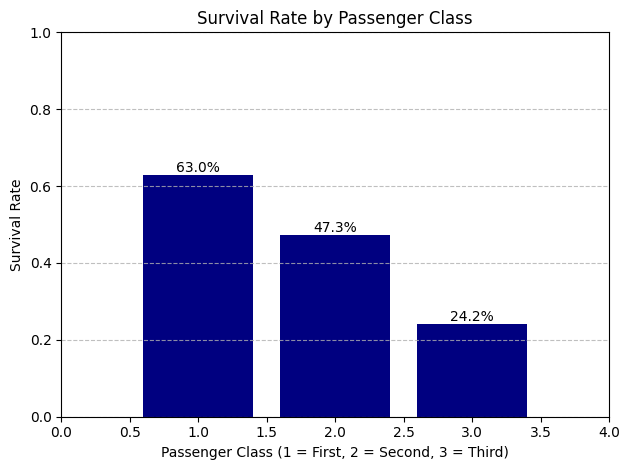

In [13]:
survival_rate = df.groupby("pclass")["survived"].mean()
plt.bar(survival_rate.index,
        survival_rate.values,
        color="navy")



for i, value in enumerate(survival_rate.values):
    plt.text(i + 1, value, f"{value*100:.1f}%", ha="center", va="bottom")

plt.ylim(0,1)
plt.xlim(0,4)

plt.title("Survival Rate by Passenger Class")
plt.xlabel("Passenger Class (1 = First, 2 = Second, 3 = Third)")
plt.ylabel("Survival Rate")
plt.grid(axis="y", alpha=0.8, linestyle="--")
plt.tight_layout()
plt.show()

#### Analyze survival patterns across different age groups (age binning required).

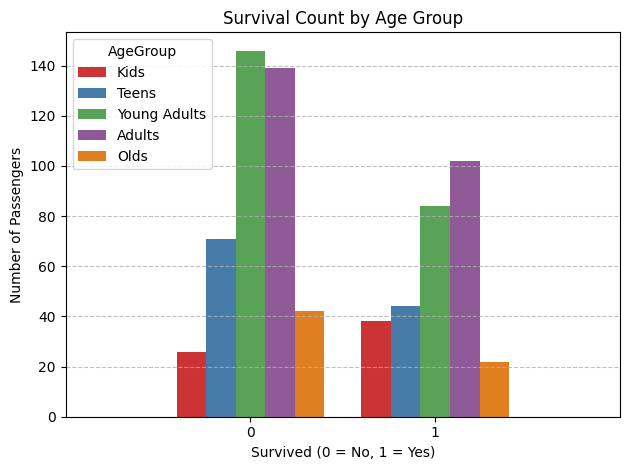

In [14]:
df["AgeGroup"] = pd.cut(df["age"],
                        bins=[0,10,20,30,50,80],
                        labels=["Kids","Teens","Young Adults", "Adults", "Olds"])


sns.countplot(data=df,
              x="survived",
              hue="AgeGroup",
              palette="Set1")


plt.title("Survival Count by Age Group")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Number of Passengers")
plt.xlim(-1,2)
plt.grid(axis="y", alpha=0.8, linestyle="--")
plt.tight_layout()
plt.show()


#### Investigate the impact of ticket fare on survival.

In [15]:
c

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='str')

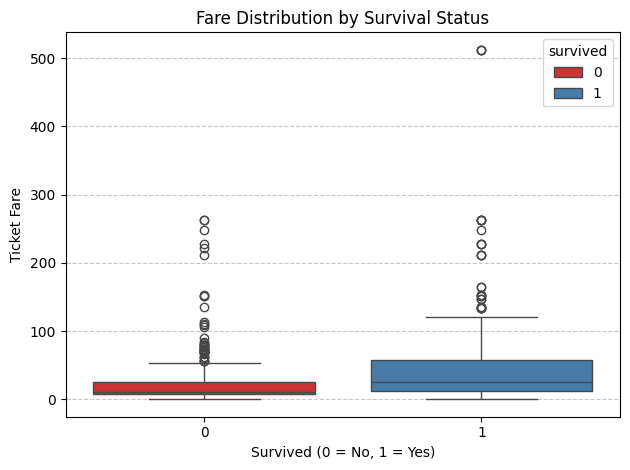

In [16]:
sns.boxplot(data=df, x="survived", y="fare", hue="survived" ,palette="Set1")

plt.title("Fare Distribution by Survival Status")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Ticket Fare")

plt.grid(axis="y", alpha=0.7, linestyle="--")
plt.tight_layout()
plt.show()

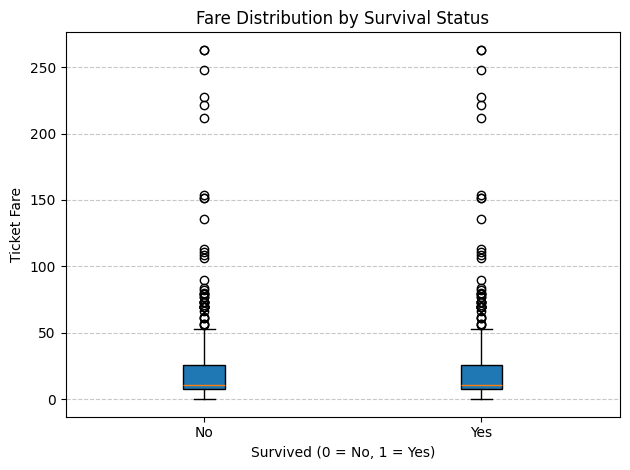

In [17]:
fare_not_survived = df[df["survived"] == 0 ]["fare"]
fare_survived = df[df["survived"] == 1 ]["fare"]


plt.boxplot([fare_not_survived, fare_not_survived],
            patch_artist=True)

plt.title("Fare Distribution by Survival Status")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Ticket Fare")

plt.xticks([1, 2], ["No", "Yes"])

plt.grid(axis="y", alpha=0.7, linestyle="--")
plt.tight_layout()
plt.show()

#### Explore survival differences by embarkation port.

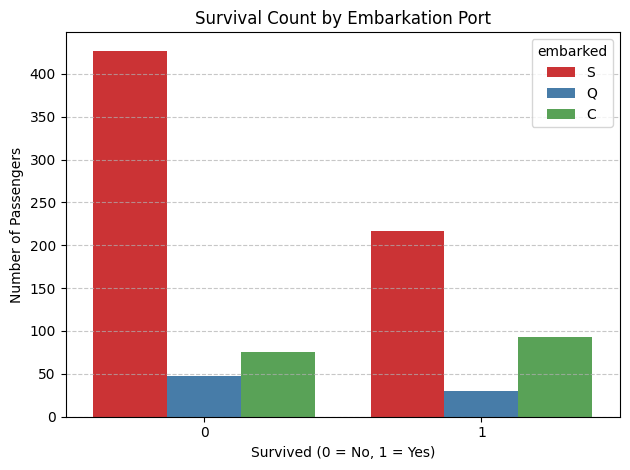

In [18]:
sns.countplot(data=df,
              x= "survived",
              hue="embarked",
              palette="Set1")


plt.title("Survival Count by Embarkation Port")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Number of Passengers")

plt.grid(axis="y", alpha=0.7, linestyle="--")
plt.tight_layout()
plt.show()

7. Analyze family size effect on survival (sibsp + parch).
8. Investigate whether passengers traveling alone had different survival rates.
9. Detect outliers in numerical features (Age, Fare).
10. Identify correlations between numerical variables and detect multicollinearity.

#### Analyze family size effect on survival (sibsp + parch)

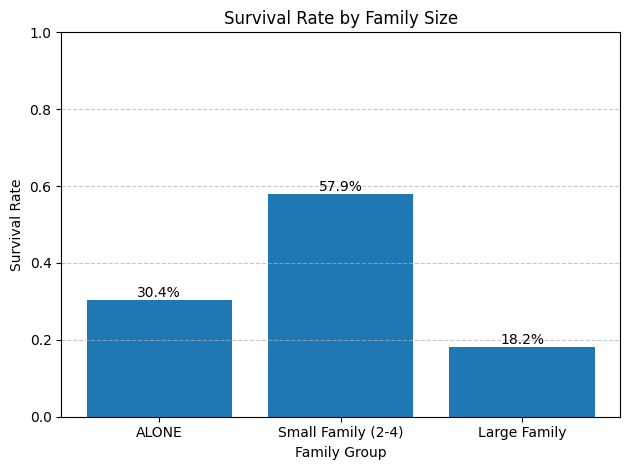

In [19]:
df["Family_Size"] = df["sibsp"] + df["parch"] + 1
df["Family_group"] = pd.cut(df["Family_Size"], bins= [0,1,4,10] , labels=["ALONE", "Small Family (2-4)", "Large Family"])

family_survival = df.groupby("Family_group")["survived"].mean()

plt.bar(family_survival.index, family_survival.values)

plt.title("Survival Rate by Family Size")
plt.xlabel("Family Group")
plt.ylabel("Survival Rate")
plt.ylim(0,1)

for i, value in enumerate(family_survival.values):
    plt.text(i, value, f"{value*100:.1f}%", ha="center", va="bottom")

plt.grid(axis="y", alpha=0.7, linestyle="--")
plt.tight_layout()
plt.show()

#### Investigate whether passengers traveling alone had different survival rates

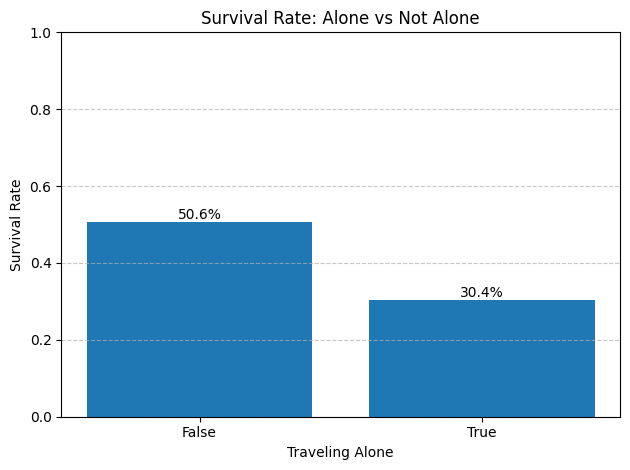

In [20]:
alone_survival = df.groupby("alone")["survived"].mean()
plt.bar(alone_survival.index.astype(str),
        alone_survival.values)

plt.title("Survival Rate: Alone vs Not Alone")
plt.xlabel("Traveling Alone")
plt.ylabel("Survival Rate")
plt.ylim(0,1)

for i, value in enumerate(alone_survival.values):
    plt.text(i, value, f"{value*100:.1f}%", ha="center", va="bottom")

plt.grid(axis="y", alpha=0.7, linestyle="--")
plt.tight_layout()
plt.show()

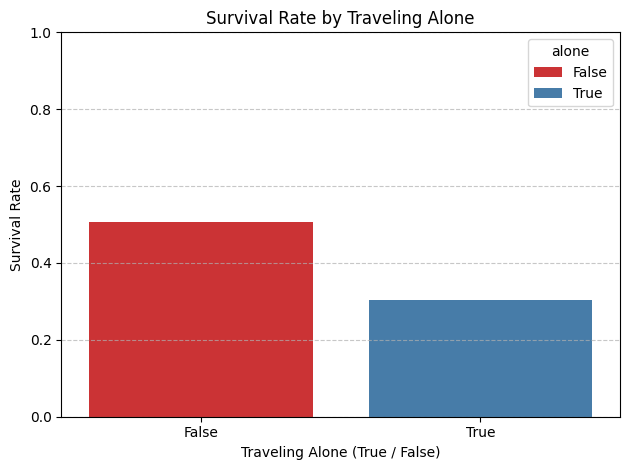

In [21]:
sns.barplot(
    data=df,
    x="alone",
    y="survived",
    estimator=np.mean,
    errorbar=None,
    hue="alone",
    palette="Set1"
)

plt.title("Survival Rate by Traveling Alone")
plt.xlabel("Traveling Alone (True / False)")
plt.ylabel("Survival Rate")
plt.ylim(0, 1)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

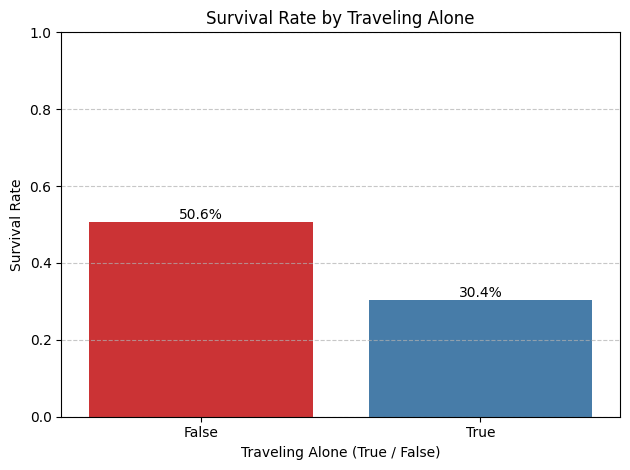

In [22]:
ax = sns.barplot(
    data=df,
    x="alone",
    y="survived",
    estimator=np.mean,
    errorbar=None,
    hue="alone",
    palette="Set1",
    legend=False
)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(i, height, f"{height*100:.1f}%", 
            ha="center", va="bottom")

plt.title("Survival Rate by Traveling Alone")
plt.xlabel("Traveling Alone (True / False)")
plt.ylabel("Survival Rate")
plt.ylim(0,1)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# DATA CLEANING

In [23]:
df.isnull().sum()

survived          0
pclass            0
sex               0
age             177
sibsp             0
parch             0
fare              0
embarked          2
class             0
who               0
adult_male        0
deck            688
embark_town       2
alive             0
alone             0
AgeGroup        177
Family_Size       0
Family_group      7
dtype: int64

In [24]:
df[df["embark_town"].isna()]
df.dropna(subset="embarked", inplace=True)

In [25]:
df.drop(columns="deck", inplace=True)

In [26]:
df["age"] =df["age"].fillna(df["age"].median())

In [27]:
df.info()

<class 'pandas.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   survived      889 non-null    int64   
 1   pclass        889 non-null    int64   
 2   sex           889 non-null    str     
 3   age           889 non-null    float64 
 4   sibsp         889 non-null    int64   
 5   parch         889 non-null    int64   
 6   fare          889 non-null    float64 
 7   embarked      889 non-null    str     
 8   class         889 non-null    category
 9   who           889 non-null    str     
 10  adult_male    889 non-null    bool    
 11  embark_town   889 non-null    str     
 12  alive         889 non-null    str     
 13  alone         889 non-null    bool    
 14  AgeGroup      712 non-null    category
 15  Family_Size   889 non-null    int64   
 16  Family_group  882 non-null    category
dtypes: bool(2), category(3), float64(2), int64(5), str(5)
memory usage: 95

In [28]:
df[["age", "AgeGroup"]]

,age,AgeGroup
0,22.0,Young Adults
1,38.0,Adults
2,26.0,Young Adults
3,35.0,Adults
4,35.0,Adults
...,...,...
886,27.0,Young Adults
887,19.0,Teens
888,28.0,NaN
889,26.0,Young Adults


In [29]:
df[df["embarked"].isna()]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone,AgeGroup,Family_Size,Family_group


In [30]:
df[df["embark_town"].isna()]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone,AgeGroup,Family_Size,Family_group


In [31]:
df[["embark_town","embarked"]]

,embark_town,embarked
0,Southampton,S
1,Cherbourg,C
2,Southampton,S
3,Southampton,S
4,Southampton,S
...,...,...
886,Southampton,S
887,Southampton,S
888,Southampton,S
889,Cherbourg,C


## 🚢 Embarked Column Documentation

The `Embarked` column in the Titanic dataset indicates the port where each passenger boarded the ship. It is a categorical feature with three possible values:

- **C** – Cherbourg  
- **Q** – Queenstown  
- **S** – Southampton  

> **Note:** During data exploration, it was observed that some entries were inconsistently labeled (e.g., `"embarked down"` vs `"embarked in"`). These entries represent the same boarding points but are recorded differently. For analysis, they should be standardized to their correct codes (`C`, `Q`, `S`) to avoid errors in grouping or modeling.

Standardizing this column ensures accurate feature analysis, group comparisons, and modeling performance.


In [32]:
df.drop(columns="embark_town", inplace=True)

In [33]:
df[["alive", "survived"]]

,alive,survived
0,no,0
1,yes,1
2,yes,1
3,yes,1
4,no,0
...,...,...
886,no,0
887,yes,1
888,no,0
889,yes,1


## 🏥 Survived / Alive Column Documentation

The Titanic dataset contains two columns representing a passenger's survival status:

- **Survived** – numerical column (`0` = did not survive, `1` = survived)  
- **Alive** – textual column (`No` = did not survive, `Yes` = survived)  

> **Note:** These columns represent the same information, just in different formats. For consistency in analysis or modeling, it's recommended to use **one standardized column** (usually `Survived`) and, if needed, map `Alive` to match numeric codes:

```python
df["Survived"] = df["Alive"].map({"No": 0, "Yes": 1})

In [34]:
df.drop(columns="alive", inplace=True)

In [35]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,alone,AgeGroup,Family_Size,Family_group
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,False,Young Adults,2,Small Family (2-4)
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,False,Adults,2,Small Family (2-4)
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,True,Young Adults,1,ALONE
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,False,Adults,2,Small Family (2-4)
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,True,Adults,1,ALONE


In [36]:
len(df.columns)

15

## 🧑 Who / Sex Column Documentation

The Titanic dataset contains two columns describing a passenger's gender/role:

- **Sex** – categorical column (`male` or `female`)  
- **Who** – categorical column (`man`, `woman`, `child`)  

> **Note:** The `Who` column is derived from `Sex` plus age information (children are separated out). Both columns carry overlapping information about gender.  
> For consistency, when analyzing gender or creating features, it's recommended to choose one primary column (`Sex`) or **create a unified feature** if both age and gender distinctions are needed.


In [37]:
df.drop(columns="who", inplace=True)

In [38]:
df[["alone","parch","sibsp"]]

,alone,parch,sibsp
0,False,0,1
1,False,0,1
2,True,0,0
3,False,0,1
4,True,0,0
...,...,...,...
886,True,0,0
887,True,0,0
888,False,2,1
889,True,0,0


## 🏠 Alone Feature Documentation

The Titanic dataset has:

- **SibSp** – number of siblings/spouses aboard  
- **Parch** – number of parents/children aboard  
- **Alone** – derived feature (`True` if passenger has no family aboard, `False` otherwise)  

> **Note:** The `Alone` feature is calculated as:

```python
df["Alone"] = ((df["SibSp"] + df["Parch"]) == 0)

In [39]:
df.drop(columns=["parch", "sibsp"], inplace=True)

## 👨 Adult Male Feature Documentation

The `adult_male` column indicates whether a passenger is an adult male (`True`) or not (`False`).  

> **Note:** This feature is redundant because the same information can be derived from:  
> - `Sex` – gives gender (`male` or `female`)  
> - `AgeGroup` – indicates age category (`Child`, `Young Adults`, `Adults`)  

Since these two columns already provide the necessary information, `adult_male` can safely be **dropped** to avoid redundancy and simplify the dataset for analysis and modeling.

In [40]:
df.drop(columns="adult_male", inplace=True)

## 🎟️ Class / Pclass Feature Documentation

The Titanic dataset contains two columns describing passenger class:

- **Pclass** – numeric (1 = First, 2 = Second, 3 = Third)  
- **class** – textual (“First”, “Second”, “Third”)  

> **Note:** These columns carry the same information. For analysis and modeling, it is recommended to keep **only `Pclass`** and drop `class` to avoid redundancy. The textual version can always be reconstructed if needed for presentation purposes:

```python
df["class"] = df["Pclass"].map({1: "First", 2: "Second", 3: "Third"})

In [41]:
df.drop(columns="class", inplace=True)

## 👪 Family_Size / Family_group Feature Documentation

The Titanic dataset contains:

- **Family_Size** – numeric count of a passenger's family aboard (`SibSp + Parch + 1`)  
- **Family_group** – categorical label based on family size:

| Family_Size | Family_group           |
|------------|-----------------------|
| 1          | ALONE                 |
| 2–4        | Small Family (2-4)    |
| 5+         | Large Family (5+)     |

> **Note:** These columns carry the same information in different formats. For modeling, you can choose **either `Family_Size` or `Family_group`**, but keeping both is redundant.  

Example:  
```python
df["Family_group"] = pd.cut(
    df["Family_Size"], 
    bins=[0,1,4,100], 
    labels=["ALONE", "Small Family (2-4)", "Large Family (5+)"]
)

In [42]:
df.drop(columns="Family_group", inplace=True)

In [43]:
df.head()

,survived,pclass,sex,age,fare,embarked,alone,AgeGroup,Family_Size
0,0,3,male,22.0,7.2500,S,False,Young Adults,2
1,1,1,female,38.0,71.2833,C,False,Adults,2
2,1,3,female,26.0,7.9250,S,True,Young Adults,1
3,1,1,female,35.0,53.1000,S,False,Adults,2
4,0,3,male,35.0,8.0500,S,True,Adults,1


## 🎂 Age / AgeGroup Feature Documentation

The Titanic dataset contains:

- **Age** – numeric value representing the passenger's age  
- **AgeGroup** – categorical bins based on age:

| AgeGroup       | Age Range         |
|----------------|-----------------|
| Child          | < 18            |
| Young Adults   | 18–35           |
| Adults         | 36–59           |
| Seniors        | 60+             |

> **Note:** `AgeGroup` is derived from `Age`. For modeling, keeping **only `Age`** is sufficient, as it preserves the full information. `AgeGroup` can still be useful for visualizations or summaries, but it is **redundant for machine learning models**.

In [44]:
df.drop(columns="AgeGroup", inplace=True)

In [45]:
le = LabelEncoder()
df["sex"] = le.fit_transform(df["sex"])

In [46]:
df["alone"] = le.fit_transform(df["alone"])

In [47]:
df["embarked"] = le.fit_transform(df["embarked"])

In [48]:
df.info()

<class 'pandas.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     889 non-null    int64  
 1   pclass       889 non-null    int64  
 2   sex          889 non-null    int64  
 3   age          889 non-null    float64
 4   fare         889 non-null    float64
 5   embarked     889 non-null    int64  
 6   alone        889 non-null    int64  
 7   Family_Size  889 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 62.5 KB


In [49]:
X = df.drop(columns="survived")
y = df["survived"]

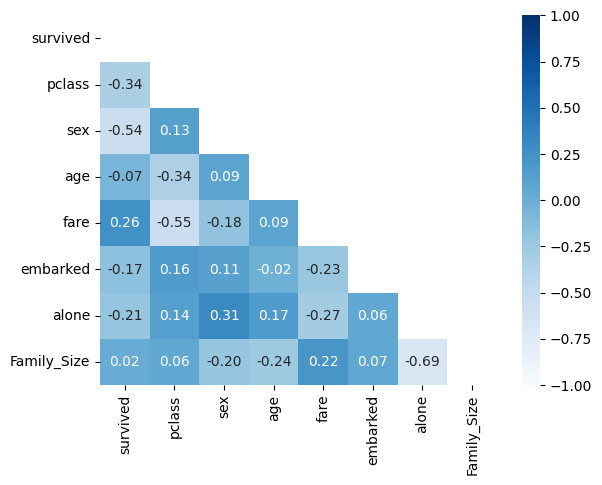

In [50]:
cor = df.corr()
mask = np.triu(np.ones_like(cor))
sns.heatmap(cor,
            mask=mask,
            annot=True,
            cmap="Blues",fmt=".2f",
            vmin=-1,
            vmax=1)


plt.show()

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y ,test_size=0.3, random_state=42)

In [52]:
pipeline = Pipeline(([
    ("scaler",StandardScaler()),
    ("Knn", KNeighborsClassifier())
]))



param_grid = {
    "Knn__n_neighbors" : [3,5,7,9],
    "Knn__weights": ["uniform", "distance"],
    "Knn__metric":["euclidean", "manhattan"]
    
}


grid = GridSearchCV(estimator=pipeline,
                    param_grid=param_grid,
                    n_jobs=-1,
                    scoring= "accuracy",
                    cv = 5)


grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

print(grid.best_estimator_)
print("***********")
print(grid.best_score_)
print("**************")
print(grid.best_params_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('Knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=9,
                                      weights='distance'))])
***********
0.8392387096774193
**************
{'Knn__metric': 'manhattan', 'Knn__n_neighbors': 9, 'Knn__weights': 'distance'}


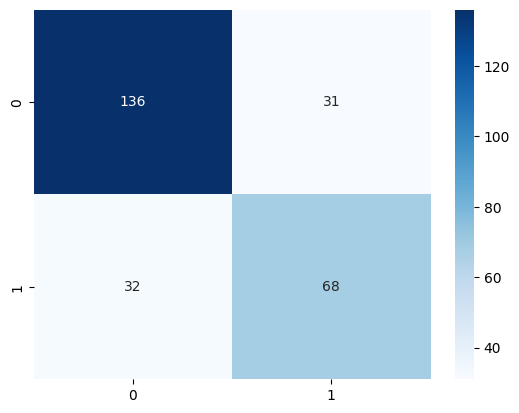

In [53]:
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True,
            fmt="d",
            cmap="Blues")

plt.show()

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       167
           1       0.69      0.68      0.68       100

    accuracy                           0.76       267
   macro avg       0.75      0.75      0.75       267
weighted avg       0.76      0.76      0.76       267



In [55]:
pipeline= Pipeline([
    ("Tree", DecisionTreeClassifier(random_state=42))
    ])


param_grid = {
    
    "Tree__criterion":["gini", "entropy"],
    "Tree__splitter":["best", "random"],
    "Tree__max_depth":[3, 5, 7, 9],
    "Tree__ccp_alpha":np.linspace(0,0.5,10).tolist()
}

grid = GridSearchCV(estimator=pipeline,
                    param_grid=param_grid,
                    cv = 5,
                    n_jobs=-1,
                    scoring="accuracy")

model = grid.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(grid.best_params_)


{'Tree__ccp_alpha': 0.0, 'Tree__criterion': 'entropy', 'Tree__max_depth': 5, 'Tree__splitter': 'best'}


In [56]:
print(grid.best_score_)

0.8263741935483871


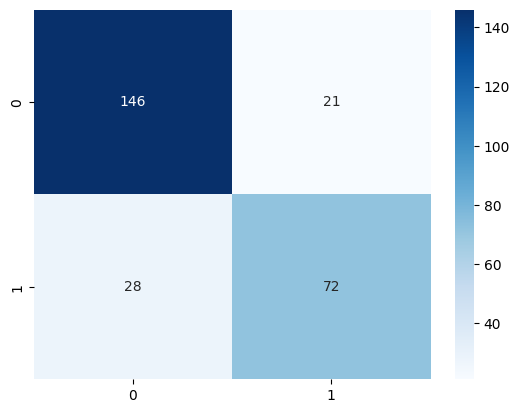

In [57]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d",cmap="Blues")
plt.show()

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       167
           1       0.77      0.72      0.75       100

    accuracy                           0.82       267
   macro avg       0.81      0.80      0.80       267
weighted avg       0.81      0.82      0.82       267



<Axes: >

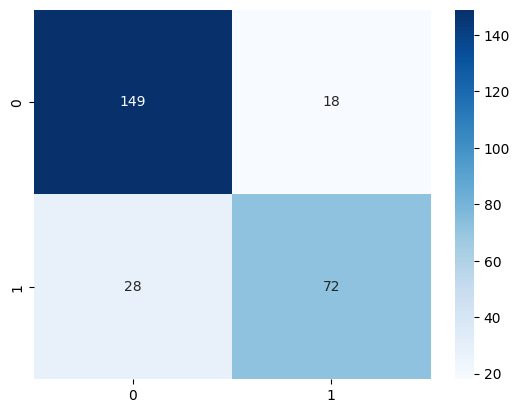

In [59]:
from sklearn.model_selection import RandomizedSearchCV
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=42))
])



distribution = {
    "svc__C" : [0.01, 0.1, 0.5, 1,],
    "svc__kernel":["rbf", "linear",],
    "svc__gamma":["scale", "auto"],
    "svc__class_weight":["balanced", None],
    "svc__max_iter":[1000, 5000, -1],
}

rs = RandomizedSearchCV(estimator=pipeline,
                        param_distributions=distribution,
                        n_iter=10,
                        n_jobs=-1,
                        cv=5,
                        scoring="accuracy")



model = rs.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True,
            fmt="d",
            cmap="Blues")


In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       167
           1       0.80      0.72      0.76       100

    accuracy                           0.83       267
   macro avg       0.82      0.81      0.81       267
weighted avg       0.83      0.83      0.83       267



In [61]:
print(rs.best_estimator_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=1, gamma='auto', random_state=42))])


In [62]:

print(rs.best_score_)

0.8295999999999999


In [63]:
print(rs.best_params_)

{'svc__max_iter': -1, 'svc__kernel': 'rbf', 'svc__gamma': 'auto', 'svc__class_weight': None, 'svc__C': 1}


In [64]:
base_models = {
    "KNN": KNeighborsClassifier(n_neighbors=5,
                                weights="uniform",
                                metric="euclidean"),
    
    "SVC": SVC(random_state=42,
               C=1.0,
               probability=True),
    
    "Logistic": LogisticRegression(random_state=42,
                                   penalty="l2",
                                   max_iter=1000),
    
    "Tree": DecisionTreeClassifier(criterion="gini",
                                   max_depth=5,
                                   splitter="best",
                                   random_state=42)
}

results = {}



for name, model in base_models.items():
    
    bag = BaggingClassifier(
        estimator=model,
        n_estimators=50,
        bootstrap=True,
        random_state=42,
        max_samples=0.8,
        max_features=0.7,
        n_jobs=-1
    )
    
    bag.fit(X_train, y_train)
    
    y_pred = bag.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    results[name] = acc

for keys, values in results.items():
    print(f"{keys}: {values:.2f}")


KNN: 0.79
SVC: 0.72
Logistic: 0.80
Tree: 0.81


In [65]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", BaggingClassifier(random_state=42))
]
)



param_grid = [
    {# Decision Tree as base model
    "model__estimator":[DecisionTreeClassifier(random_state=42)],
    "model__estimator__splitter": ["best", "random"],
    "model__estimator__criterion": ["gini", "entropy"],
    "model__estimator__max_depth": [3, 5, 7],
    "model__estimator__ccp_alpha": [1,3,5],
    "model__n_estimators": [100],
    "model__max_samples": [0.6, 0.8, 1.0],
    "model__max_features": [0.6, 0.8, 1.0],
    "model__bootstrap": [True],
    "model__bootstrap_features": [False, True],
    
    },
    {# Support vector machine as base model
        "model__estimator": [SVC(random_state=42)],
        "model__estimator__C":np.linspace(0.1,1,5).tolist(),
        "model__estimator__kernel":["rbf", "linear"],
        "model__estimator__gamma": ["scale", "auto"],
        "model__n_estimators": [100],
        "model__max_samples": [0.6, 0.8, 1.0],
        "model__max_features": [0.6, 0.8, 1.0],
        "model__bootstrap": [True],
        "model__bootstrap_features": [False, True]}
]


grid = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions= param_grid,
    cv = 5,
    scoring="accuracy",
    n_jobs = -1,
    n_iter= 10
)

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))
print(grid.best_estimator_)
print(grid.best_params_)
print(grid.best_score_)

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       167
           1       0.79      0.72      0.75       100

    accuracy                           0.82       267
   macro avg       0.82      0.80      0.81       267
weighted avg       0.82      0.82      0.82       267

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 BaggingClassifier(estimator=SVC(C=0.55, random_state=42),
                                   max_samples=1.0, n_estimators=100,
                                   random_state=42))])
{'model__n_estimators': 100, 'model__max_samples': 1.0, 'model__max_features': 1.0, 'model__estimator__kernel': 'rbf', 'model__estimator__gamma': 'scale', 'model__estimator__C': 0.55, 'model__estimator': SVC(random_state=42), 'model__bootstrap_features': False, 'model__bootstrap': True}
0.8231483870967743


In [66]:
from sklearn.ensemble import RandomForestClassifier

param = RandomForestClassifier()
for model , value in param.get_params().items():
    print(model, value)

bootstrap True
ccp_alpha 0.0
class_weight None
criterion gini
max_depth None
max_features sqrt
max_leaf_nodes None
max_samples None
min_impurity_decrease 0.0
min_samples_leaf 1
min_samples_split 2
min_weight_fraction_leaf 0.0
monotonic_cst None
n_estimators 100
n_jobs None
oob_score False
random_state None
verbose 0
warm_start False


In [74]:
pipeline = Pipeline([
    ("RF", RandomForestClassifier(random_state=42))
])


param_distribution = {
    "RF__ccp_alpha": [0.0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02],
    "RF__criterion": ["gini", "entropy"],
    "RF__max_depth": [1,3,5],
    "RF__class_weight":["balanced"],
    "RF__max_samples":[None,3,5,7]
}


grid = RandomizedSearchCV(estimator=pipeline,
                          param_distributions=param_distribution,
                          cv = 5,
                          n_iter=10,
                          n_jobs=-1,
                          scoring="accuracy"
                          )


grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       167
           1       0.74      0.75      0.74       100

    accuracy                           0.81       267
   macro avg       0.79      0.79      0.79       267
weighted avg       0.81      0.81      0.81       267



In [73]:
pipeline = Pipeline([
    ("model",AdaBoostClassifier(
        estimator= DecisionTreeClassifier(),
    ))
])

param_grid = {
    "model__n_estimators": [50 , 100],
    "model__learning_rate": [0.5, 0.7, 1],
    "model__estimator__max_depth": [3, 5,7]
}

grid = GridSearchCV(estimator=pipeline,
                    param_grid=param_grid,
                    scoring="accuracy",
                    cv = 5,
                    n_jobs=-1,
                    verbose=2
                    )

# Train
grid.fit(X_train, y_train)

# Predict
y_pred = grid.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Accuracy: 0.7827715355805244
[[137  30]
 [ 28  72]]
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       167
           1       0.71      0.72      0.71       100

    accuracy                           0.78       267
   macro avg       0.77      0.77      0.77       267
weighted avg       0.78      0.78      0.78       267

